In [1]:
# quick idea: if you deconvolve the aberrated PSF using the unaberrated one, you can get a tighter estimate of a spot

# I have hcipy as a submodule, so this import may vary
import sys
sys.path.append("..")
from hcipy.hcipy import *

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage, signal, optimize, stats

D = 10.95 #m
pupil_size = 10
focal_samples = 20 # samples per lambda over D
focal_width = 5 # the number of lambda over Ds
s = focal_samples * pupil_size

wavelength = 500e-9 # m
f_sampling = 1000
T = 1
times = np.arange(0, T, 1/f_sampling)
pupil_grid = make_pupil_grid(pupil_size)
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, focal_samples, focal_width, wavelength=wavelength)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
aperture = circular_aperture(1)(pupil_grid)
fried_parameter = 0.2 # meter
outer_scale = 20 # meter
velocity = 10 # meter/sec
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity, use_interpolation=True)

In [2]:
tt = [zernike(*ansi_to_zernike(i), 1)(pupil_grid) for i in (1, 2)] # tip-tilt phase basis
base_wf = Wavefront(aperture, wavelength)
psf = prop(base_wf).intensity
grid = psf.grid
psf = np.array(psf.reshape((s,s)))
star = prop(Wavefront(base_wf.electric_field * np.exp(1j * np.pi * tt[1]), wavelength)).intensity
star = np.array(star.reshape((s,s)))

(200, 200)


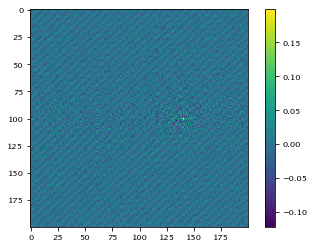

In [3]:
# https://stackoverflow.com/questions/17473917/is-there-a-equivalent-of-scipy-signal-deconvolve-for-2d-arrays

print(star.shape)

from scipy import fftpack

def convolve(star, psf):
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft*psf_fft)))

def deconvolve(star, psf):
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft/psf_fft)))

star_deconv = deconvolve(star, psf)
plt.imshow(np.real(star_deconv))
plt.colorbar()
plt.show()

In [11]:
def center_of_mass(f):
    dims = np.array([np.max(f.grid.x) - np.min(f.grid.x), np.max(f.grid.y) - np.min(f.grid.y)])
    average = np.array([(f.grid.x * f).sum(), (f.grid.y * f).sum()]) / (f.sum())
    return average * focal_width * focal_samples / dims

print(center_of_mass(Field(star.flatten(), focal_grid)))
print(center_of_mass(Field(np.real(star_deconv).flatten()**20, focal_grid)))

[ 1.85178960e+01 -4.79701326e-15]
[2.01003173e+01 6.89477470e-04]
